In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow.keras as ke
import os

from tensorflow.keras.layers import Dense, BatchNormalization


import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

from tensorflow.keras.layers import Dense, BatchNormalization

import random
from itertools import permutations

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

%matplotlib inline

In [3]:
# Read the regrouped data from group 1 to 9; drop the gender column
#file_path_train = './normal_female/train.csv'
#file_path_test =  './normal_female/valid.csv'

file_path_train = './normal_AllGender/train.csv'
#file_path_test =  './normal_AllGender/valid.csv'
file_path_test =  './normal_AllGender/test.csv'

df_train = pd.read_csv(file_path_train, sep = ',')
#df_train = df_train.drop(['Gender'], axis=1)
X_train = df_train.drop(['Group'], axis=1)
y_train = df_train['Group']

df_test = pd.read_csv(file_path_test, sep = ',')
#df_test = df_test.drop(['Gender'], axis=1)
X_test = df_test.drop(['Group'], axis=1)
y_test = df_test['Group']
X_test

,QRS_Duration__ms_C,R_T_Axis_deviation,Gender,Ventricular_Rate_C,P_Axis_C,R_Axis_C,T_Axis_C,QTc_Calculation_C,QTc_Bazett_C,QTc_Friderica_C,...,P_Peak_Amplitude_C_aVR,Q_Peak_Amplitude_C_aVR,R_Peak_Amplitude_C_aVR,S_Peak_Amplitude_C_aVR,T_Peak_Amplitude_C_aVR,Q_Area_C_aVR,R_Area_C_aVR,S_Area_C_aVR,T_Area_C_aVR,Summated_QRS_integral_aVR
0,96.0,35.0,0,70.0,45.0,93.0,58.0,427.0,135,417,...,-78.0,712.0,390.0,0.0,-302.0,616.0,616.0,0.0,-1652.0,1232.0
1,88.0,16.0,1,106.0,28.0,65.0,49.0,448.0,142,409,...,-112.0,0.0,126.0,1230.0,-258.0,0.0,76.0,1017.0,-1354.0,1093.0
2,92.0,-85.0,0,123.0,39.0,-12.0,73.0,401.0,127,356,...,-126.0,1108.0,380.0,0.0,-219.0,1084.0,305.0,0.0,-1034.0,1389.0
3,58.0,70.0,0,170.0,67.0,82.0,12.0,433.0,137,365,...,-131.0,800.0,634.0,0.0,-151.0,481.0,466.0,0.0,-648.0,947.0
4,98.0,50.0,0,59.0,32.0,69.0,19.0,413.0,131,416,...,-107.0,644.0,278.0,0.0,-278.0,683.0,400.0,0.0,-1622.0,1083.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6013,96.0,21.0,0,116.0,68.0,81.0,60.0,444.0,141,399,...,-131.0,0.0,92.0,971.0,-239.0,0.0,45.0,812.0,-1082.0,857.0
6014,84.0,4.0,0,79.0,53.0,62.0,58.0,435.0,138,416,...,-107.0,834.0,200.0,0.0,-234.0,938.0,148.0,0.0,-1033.0,1086.0
6015,70.0,13.0,0,94.0,58.0,51.0,38.0,446.0,141,414,...,-131.0,903.0,146.0,0.0,-209.0,870.0,65.0,0.0,-1462.0,935.0
6016,90.0,29.0,0,76.0,70.0,98.0,69.0,446.0,138,420,...,-122.0,678.0,307.0,39.0,-405.0,739.0,256.0,19.0,-2618.0,1014.0


In [4]:
epochs = 200
batch_size = 256
logging_step = 5

z_dim = 100
image_shape = (13, 13, 1)#(21, 8, 1)
hidden_layer_size = 512

relu_leak = 0.2
init_lr = 0.000001

initializer = ke.initializers.RandomNormal(stddev=0.02)
regularizer = ke.regularizers.l2(2.5e-5)
optimizer = ke.optimizers.Adam(learning_rate=init_lr, beta_1=0.5)

In [5]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training and test data using the scaler
X_train = scaler.transform(X_train).reshape(-1, image_shape[0], image_shape[1], image_shape[2])
X_test = scaler.transform(X_test).reshape(-1, image_shape[0], image_shape[1], image_shape[2])


In [6]:
models_prefix = 'Tmodelsageclf100All/'
images_prefix = 'Timagesageclf100All/'

if not os.path.exists(models_prefix):
  os.mkdir(models_prefix)

if not os.path.exists(images_prefix):
  os.mkdir(images_prefix)

In [7]:
def generator():
  model = ke.models.Sequential()
  
  model.add(ke.layers.Dense(hidden_layer_size, input_dim=z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.ReLU())
  model.add(ke.layers.BatchNormalization())
  
  model.add(ke.layers.Dense(np.prod(image_shape), activation='sigmoid',
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.Reshape(image_shape))
  
  return model
     

In [8]:
def encoder():
  model = ke.models.Sequential()
  model.add(ke.layers.Flatten(input_shape=image_shape))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  
  model.add(ke.layers.Dense(hidden_layer_size,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))
  
  model.add(ke.layers.LeakyReLU(alpha=relu_leak))
  model.add(BatchNormalization()) # workaround
  
  model.add(ke.layers.Dense(z_dim,
                            kernel_initializer=initializer, kernel_regularizer=regularizer))

  return model
     

In [9]:
def discriminator():
  z_ = ke.layers.Input(shape=(z_dim,))
  image_ = ke.layers.Input(shape=image_shape)
  input_ = ke.layers.concatenate([z_, ke.layers.Flatten()(image_)])

  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(input_)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  model = ke.layers.Dense(hidden_layer_size,
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)
  
  model = ke.layers.LeakyReLU(alpha=relu_leak)(model)
  
  output = ke.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=initializer, kernel_regularizer=regularizer)(model)

  return ke.models.Model([z_, image_], output)

In [10]:
def triplet_loss(y_true, y_pred):
    anchor = y_pred[:, :z_dim]
    positive = y_pred[:, z_dim : z_dim * 2]
    negative = y_pred[:, 2 * z_dim:]

    dist_pos = ke.backend.sum(ke.backend.square(anchor - positive), axis = 1)
    dist_neg = ke.backend.sum(ke.backend.square(anchor - negative), axis = 1)

    loss = dist_pos - dist_neg + 0.3
    
    return ke.backend.maximum(0.0, loss)

In [11]:
def build_T_bigan():
  D = discriminator()
  D.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
  D.trainable = False
  
  G = generator()
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  image = ke.layers.Input(shape=image_shape)
  image_pos = ke.layers.Input(shape=image_shape)
  image_neg = ke.layers.Input(shape=image_shape)
  
  E = encoder()
  z_ = E(image)
  z_pos = E(image_pos)
  z_neg = E(image_neg)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  triplet = ke.layers.concatenate([z_, z_pos, z_neg])
  
  T_BiGAN = ke.models.Model([z, image, image_pos, image_neg], [D_real, D_fake, triplet])
  T_BiGAN.compile(optimizer=optimizer,
                  loss=['binary_crossentropy', 'binary_crossentropy', triplet_loss])
  
  return G, E, D, T_BiGAN
     

In [12]:
def load_T_bigan(G, E, D):
  z = ke.layers.Input(shape=(z_dim, ))
  image_ = G(z)

  image = ke.layers.Input(shape=image_shape)
  image_pos = ke.layers.Input(shape=image_shape)
  image_neg = ke.layers.Input(shape=image_shape)
  
  z_ = E(image)
  z_pos = E(image_pos)
  z_neg = E(image_neg)
  
  D_real = D([z_, image])
  D_fake = D([z, image_])
  triplet = ke.layers.concatenate([z_, z_pos, z_neg])
  
  T_BiGAN = ke.models.Model([z, image, image_pos, image_neg], [D_real, D_fake, triplet])
  T_BiGAN.compile(optimizer=optimizer,
                  loss=['binary_crossentropy', 'binary_crossentropy', triplet_loss])
  
  return T_BiGAN

In [13]:
def create_triplets(X, y, size = 100): # check 10000 here
  triplets = []
  
  for digit in set(y):
    indices_pos = np.where(y == digit)[0]
    indices_neg = np.where(y != digit)[0]
    
    positives = random.sample(list(permutations(indices_pos, 2)), k = size)
    negatives = random.sample(list(indices_neg), k = size)
    
    for pair in positives:
      anchor = X[pair[0]]
      positive = X[pair[1]]
      
      for idx in negatives:
        negative = X[idx]
        triplets.append([anchor, positive, negative])

  return np.array(triplets)

In [14]:
def qualitative_results(n = 20):
  z = np.random.uniform(-1, 1, (n, z_dim))
  generated = G.predict(z)
  
  real_images = X_test[np.random.choice(len(X_test), n)]
  latent_codes = E.predict(real_images)
  reconstructions = G.predict(latent_codes)
  
  fig, axs = plt.subplots(3, n)
  
  for i in range(n):
    axs[0, i].imshow(generated[i, :, :, 0], cmap='gray')
    axs[1, i].imshow(real_images[i, :, :, 0], cmap='gray')
    axs[2, i].imshow(reconstructions[i, :, :, 0], cmap='gray')
    for j in range(3):
      axs[j, i].axis('off')
  
  return fig
     

In [15]:
def train():
  batches = int(len(X_train) / batch_size)
  
  anchors = triplets[:,0]
  positives = triplets[:,1]
  negatives = triplets[:,2]
  
  ones = np.ones(batch_size)
  zeros = np.zeros(batch_size)
  dummy = np.empty(batch_size)

  for epoch in range(epochs):
    for batch in range(batches):
      indices = np.random.choice(len(triplets), batch_size)
      z = np.random.uniform(-1, 1, (batch_size, z_dim))
      
      images = anchors[indices]
      images_pos = positives[indices]
      images_neg = negatives[indices]
      
      z_ = E.predict(images)
      images_ = G.predict(z)

      loss_D_fake = D.train_on_batch([z, images_], zeros)
      loss_D_real = D.train_on_batch([z_, images], ones)
      loss_T_E_G = T_BiGAN.train_on_batch([z, images, images_pos, images_neg], [zeros, ones, dummy])
      
    if epoch % logging_step == 0:
      D_loss = (loss_D_fake[0] + loss_D_real[0]) * 0.5
      acc_fake = loss_D_fake[1] * 100.0
      acc_real = loss_D_real[1] * 100.0
      loss_E_G = loss_T_E_G[1] + loss_T_E_G[2]
      loss_T   = loss_T_E_G[3]
      
      print('[Epoch {}] (Disc loss: {:.2f}, acc_fake: {:.1f}%, acc_real: {:.1f}%) (E_G loss: {:.2f}) (T loss: {:.3f})'.
            format(epoch, D_loss, acc_fake, acc_real, loss_E_G, loss_T))
      
      fig = qualitative_results()
      fig.savefig(images_prefix + 'T_{}.png'.format(epoch))
      plt.close()

In [16]:
def load_trained_models(models_prefix, encoder, generator, discriminator):
    
    # load weights into new model
    encoder.load_weights(models_prefix + 'T_E_weights.hdf5')

    
    # load weights into new model
    generator.load_weights(models_prefix + 'T_G_weights.hdf5')

    
    # load weights into new model
    discriminator.load_weights(models_prefix  + 'T_D_weights.hdf5')
    
    return encoder, generator, discriminator

In [17]:
LOAD_MODELS = 1

if LOAD_MODELS:
    
  G, E, D, T_BiGAN = build_T_bigan()
  E, G, D = load_trained_models(models_prefix, E, G, D)

#  G = ke.models.load_model(models_prefix + 'T_G.h5')
#  E = ke.models.load_model(models_prefix + 'T_E.h5')
#  D = ke.models.load_model(models_prefix + 'T_D.h5')
  T_BiGAN = load_T_bigan(G, E, D)
    
    
else:
  G, E, D, T_BiGAN = build_T_bigan()

2023-07-19 17:12:50.250876: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-19 17:12:50.251316: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [18]:
TRAIN_MODELS = 0

if TRAIN_MODELS:
  triplets = create_triplets(X_train, y_train)
  print('Triplets shape: {}'.format(triplets.shape))
  train()

SAVE_MODELS = 0

if SAVE_MODELS:
    G.save_weights(models_prefix + 'T_G_weights.hdf5')
    E.save_weights(models_prefix + 'T_E_weights.hdf5')
    D.save_weights(models_prefix + 'T_D_weights.hdf5')

In [24]:
def ONN_accuracy():
  latent_codes = E.predict(X_test)
  ONN = NearestNeighbors(n_neighbors=2, algorithm='brute').fit(latent_codes)
  
  _, indices = ONN.kneighbors(latent_codes)
  results = (y_test == y_test[indices[:]])
  
  print('One Nearest Neighbors (1NN) classification accuracy: {}%'.format(100. * np.mean(results)))

In [39]:
from matplotlib.cm import ScalarMappable
def TSNE_embedding(X, y, n,name):
  latent_codes = E.predict(X[:n])
  embedding = TSNE().fit_transform(latent_codes)
  
  ax = plt.subplot(1, 1, 1)
  #ax.scatter(embedding[:, 0], embedding[:, 1], c=y[:n], cmap=plt.cm.get_cmap('RdYlBu'))
  scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=y[:n], cmap=plt.cm.get_cmap('RdYlBu'))

  # Add a colorbar with class labels
  cbar = plt.colorbar(scatter)
  cbar.set_ticks(range(1,10))  # Set the tick positions
  #cbar.set_ticklabels(y[:n])  # Set the tick labels

  ax.axis('off')

  plt.savefig(name + '.tiff', dpi=300)

  #plt.savefig(name + '.pdf', format='pdf')
  plt.show()

In [42]:
gender_test = X_test.reshape(-1,169)[:,2]
y_test_copy = y_test

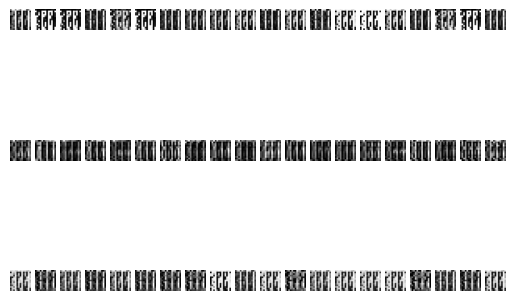

/opt/miniconda3/envs/bigan/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/miniconda3/envs/bigan/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


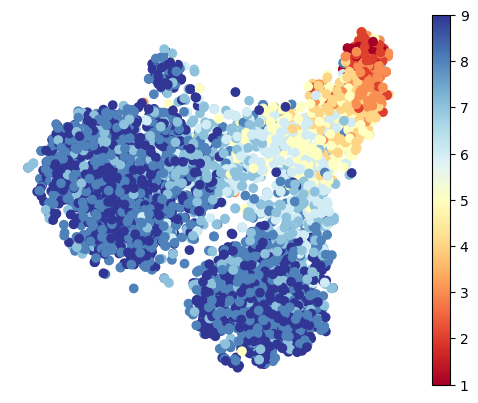

In [50]:
EVALUATE_MODELS = 1

if EVALUATE_MODELS:
  qualitative_results()
  plt.show()
  
  #ONN_accuracy()
  
  #TSNE_embedding(X_train, y_train, len(y_test), images_prefix + 'trainsex1')
  TSNE_embedding(X_test[gender_test == 0,:,:,:], y_test[gender_test == 0], len(y_test),images_prefix + 'testsex0')

In [58]:
from sklearn.preprocessing import normalize

import seaborn as sns
def sgd_classifier(x_train,x_test,y_train,y_test, alpha = 6e-2):
    # Compute class weights to handle imbalanced data
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)

    # Create the model
    #clf = SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced', alpha=alpha, random_state=42, max_iter=1e6, tol=1e-1)
    clf = SVC( class_weight='balanced', kernel = 'rbf', random_state=42, max_iter=1e6, tol=1e-1)
    #clf = SVC( class_weight='balanced', kernel = 'rbf', random_state=42, max_iter=1e6, tol=1e-1)

    # Train the model
    clf.fit(x_train, y_train)

    # Predict on the test set
    y_pred = clf.predict(x_test)
    
    
    
    y_test = y_test_copy[gender_test == 1]
    y_pred = y_pred[gender_test == 1]
    

    # Calculate the accuracy
    accuracy = accuracy_score(y_test + 1, y_pred + 1)
    print("Accuracy:", accuracy)
    
    
    # Assuming you have y_test and y_pred
    conf_matrix = confusion_matrix(y_test, y_pred)
    norm_conf_matrix = normalize(conf_matrix, axis=1, norm='l1')

    # Creating the heatmap
    sns.heatmap(norm_conf_matrix, annot=True, cmap='Blues', fmt='.2f')

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Normalized Confusion Matrix')
    
    
    # Save the graph as a high-resolution TIFF image
    name = images_prefix + 'TBiGANConf_agesex1, Accuracy: ' + "{:.2f}".format(accuracy)
    plt.savefig(name + '.tiff', dpi=300)
    plt.show()


Accuracy: 0.5388956066102378


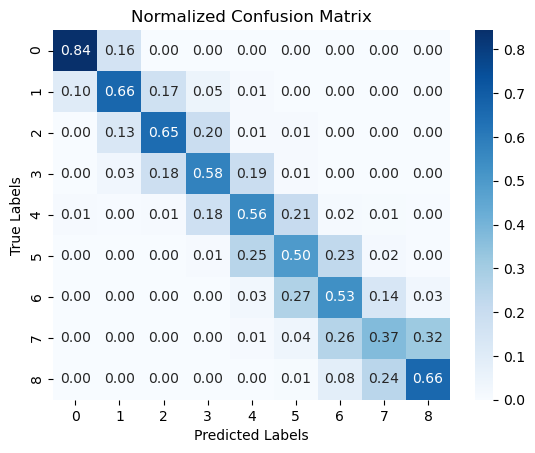

In [59]:
sgd_classifier(E.predict(X_train),E.predict(X_test),y_train,y_test, alpha = 6e-2)